In [1]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from svgpathtools import svg2paths

In [2]:
# ------ plot color wheel ------
def plot_wheel(t_type, fig=plt.figure(), sub=None, all=False):
    # generate random data
    theta = np.linspace(0, 2*np.pi, 360)
    r = np.random.uniform(0.8, 1, 360)

    T, R = np.meshgrid(theta, r)  # create a meshgrid for pcolormesh
    C = T / (2*np.pi)  # create the color values for each meshgrid point

    # plot the polar plot
    if not all:
        ax = fig.add_subplot(111, projection='polar')
    else:
        ax = fig.add_subplot(sub, projection='polar')
    ax.set_axis_off()

    # hue wheel
    ax.pcolormesh(T, R, C, cmap=cm.hsv)

    # gray region
    if t_type == "i":
        a0, a1, b0, b1 = 81 * np.pi / 180, 99 * np.pi / 180, 0, 0
    elif t_type == "V":
        a0, a1, b0, b1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180, 0, 0
    elif t_type == "L":
        a0, a1 = 81 * np.pi / 180, 99 * np.pi / 180
        b0, b1 = 39.6 * np.pi / 180, -39.6 * np.pi / 180
    elif t_type == "I":
        a0, a1 = 81 * np.pi / 180, 99 * np.pi / 180
        b0, b1 = 261 * np.pi / 180, 279 * np.pi / 180
    elif t_type == "T":
        a0, a1, b0, b1 = np.pi/2, -np.pi/2, 0, 0
    elif t_type == "Y":
        a0, a1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180
        b0, b1 = 261 * np.pi / 180, 279 * np.pi / 180
    elif t_type == "X":
        a0, a1 = 43.2 * np.pi / 180, 136.8 * np.pi / 180
        b0, b1 = 223.2 * np.pi / 180, 316.8 * np.pi / 180
    elif t_type == "N":
        a0, a1, b0, b1 = 0, 0, 0, 0
    theta = np.linspace(a0, a1, 100)
    ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')
    theta = np.linspace(b0, b1, 100)
    ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')

    # center
    ax.scatter(0, 0, color='black', marker='o', s=50)
    plt.title(t_type)
    if not all: plt.show()

# fig = plt.figure(figsize=(10, 6))
# plot_wheel("i", fig, 241, True)
# plot_wheel("V", fig, 242, True)
# plot_wheel("L", fig, 243, True)
# plot_wheel("I", fig, 244, True)
# plot_wheel("T", fig, 245, True)
# plot_wheel("Y", fig, 246, True)
# plot_wheel("X", fig, 247, True)
# plot_wheel("N", fig, 248, True)
# plt.show()

<Figure size 640x480 with 0 Axes>

In [104]:
# ------ read icon and preprocessing ------
# read svg file
paths, attributes = svg2paths('030-storm-14.svg')
rgb = []
hue = []
hs = []

# extract colors and convert to hsv
for ele in attributes:
    if 'style' in ele:
        hex = ele['style'].split('#')[1].replace(';', '')
        _rgb = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))  # hex to rgb
        hsv = colorsys.rgb_to_hsv(_rgb[0]/255.0, _rgb[1]/255.0, _rgb[2]/255.0)  # rgb to hsv
        if int(hsv[0]*360) == 360: h = 0  # 360 is the same as 0
        else: h = int(hsv[0]*360)
        rgb.append(np.array(_rgb)/255.0)
        hue.append(h)
        hs.append([h, hsv[1]])
        
# print(hue)
# print(hs)

# convert input color to vector with probability
vec = [1/len(set(hue)) if i in set(hue) else 0 for i in range(360)]
for i in set(hue):
    prob = hue.count(i) / len(hue)  # probability of occurrence = times / number of colors
    vec[i] = prob
vec = np.array(vec)
# print(vec)

In [105]:
# ------ calculate the distance between input colors and templates ------
# ------ use vector and probability distribution ------
tm = dict()
alpha = 0
tm["X"] = np.array([1]*94 + [alpha]*86 + [1]*94 + [alpha]*86)
tm["L"] = np.array([1]*18 + [alpha]*41 + [1]*79 + [alpha]*222)
tm["Y"] = np.array([1]*94 + [alpha]*124 + [1]*18 + [alpha]*124)
tm["I"] = np.array([1]*18 + [alpha]*162 + [1]*18 + [alpha]*162)
tm["T"] = np.array([1]*180 + [alpha]*180)
tm["V"] = np.array([1]*94 + [alpha]*266)
tm["i"] = np.array([1]*18 + [alpha]*342)

# shift hue wheel
def shift_hue(arr, t):
    n = len(arr)
    return np.concatenate((arr[-t % n:], arr[:-t % n]))

# find valid region
def find_region(arr, tm):
    idx = 0
    if arr[0] == 1 and arr[-1] != 1:
        idx = 0
    else:
        for i in range(1, 360):
            if arr[i] == 1 and arr[i-1] == 0:
                idx = i
                break
            
    if tm == 'i': return [idx, idx+18-1, 0, 0]
    elif tm == 'V': return [idx, idx+94-1, 0, 0]
    elif tm == 'L': return [idx, idx+18-1, idx+18+41, idx+18+41+79-1]
    elif tm == 'I': return [idx, idx+18-1, idx+18+162, idx+18+162+18-1]
    elif tm == 'T': return [idx, idx+180-1, 0, 0]
    elif tm == 'Y': return [idx, idx+94-1, idx+94+124, idx+94+124+18-1]
    elif tm == 'X': return [idx, idx+94-1, idx+94+86, idx+94+86+94-1]
    else: return [0, 0, 0, 0]

best_tm = (None, -1)
region_tm = [0, 0, 0, 0]
for t, v in tm.items():
    if t in ['I', 'X']:
        for i in range(180):
            v = shift_hue(v, i)  # i = 0 to 179
            cos_sim = np.dot(vec, v) / (np.linalg.norm(vec) * np.linalg.norm(v))
            if (cos_sim > best_tm[1]):
                best_tm = (t, cos_sim)
                region_tm = find_region(v, t)
    else:
        for i in range(360):
            v = shift_hue(v, i)  # i = 0 to 359
            cos_sim = np.dot(vec, v) / (np.linalg.norm(vec) * np.linalg.norm(v))
            if (cos_sim > best_tm[1]):
                best_tm = (t, cos_sim)
                region_tm = find_region(v, t)
                
region_tm = np.array(region_tm)
print("hue:", hue)
print("best template: ", best_tm)
print("region:", region_tm)  

hue: [199, 205, 45, 206, 198]
best template:  ('i', 0.42163702135578396)
region: [190 207   0   0]


In [106]:
# ------ calculate the distance between input colors and templates ------
# ------ only use angle diff (w/o probability distribution) ------

# when alpha = 0, the valid region for each template (except N)
templates = dict()  # in order !!!!!!!!
templates["X"] = np.array([0, 93.6, 180, 273.6])
templates["L"] = np.array([0, 79.2, 120.6, 138.6])
templates["Y"] = np.array([0, 93.6, 217.8, 235.8])
templates["I"] = np.array([0, 18, 180, 198])
templates["T"] = np.array([0, 180])
templates["V"] = np.array([0, 93.6])
templates["i"] = np.array([0, 18])


# hue distance between image and template
best = (None, float('inf'))
region = [0, 0, 0, 0]

for t, v in templates.items():
    # single region
    if t in ['i', 'V', 'T']:
        for i in range(360):
            distance = 0
            for h in hue:
                if ((v[0] < v[1] and (h < v[0] or h > v[1])) or\
                    (v[0] > v[1] and (h < v[0] and h > v[1]))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(360-h+v[0]), abs(360-h+v[1]))
            if distance < best[1]:
                best = (t, distance)
                region[:2] = v
            v = (v + 1) % 360
            
    # symmetric
    elif t in ['I', 'X']:
        for i in range(180):
            distance = 0
            for h in hue:
                if ((v[2] < v[3] and ((h < v[0] or h > v[1]) and (h < v[2] or h > v[3]))) or\
                    (v[2] > v[3] and ((h < v[0] or h > v[1]) and (h < v[2] and h > v[3])))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(h-v[2]), abs(h-v[3]),
                                    abs(360-h+v[0]), abs(360-h+v[1]), abs(360-h+v[2]), abs(360-h+v[3]))
            if distance < best[1]:
                best = (t, distance)
                region = v
            v = (v + 1) % 360
                    
    # double region (L and Y)
    else:
        for i in range(360):
            distance = 0
            for h in hue:
                if (((v[0] < v[1] and v[2] < v[3]) and ((h < v[0] or h > v[1]) and (h < v[2] or h > v[3])))or\
                    ((v[0] > v[1] and v[2] < v[3]) and ((h < v[0] and h > v[1]) and (h < v[2] or h > v[3])))or\
                    ((v[0] < v[1] and v[2] > v[3]) and ((h < v[0] or h > v[1]) and (h < v[2] and h > v[3])))):
                    distance += min(abs(h-v[0]), abs(h-v[1]), abs(h-v[2]), abs(h-v[3]),
                                    abs(360-h+v[0]), abs(360-h+v[1]), abs(360-h+v[2]), abs(360-h+v[3]))
            if distance < best[1]:
                best = (t, distance)
                region = v
            v = (v + 1) % 360
            
print("hue:", hue)
print("best template: ", best)
print("region:", region)                

hue: [199, 205, 45, 206, 198]
best template:  ('X', 0)
region: [  0.   93.6 180.  273.6]


C:\Users\ivy87\AppData\Local\Temp\ipykernel_17540\2580002843.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(T, R, C, cmap=cm.hsv)


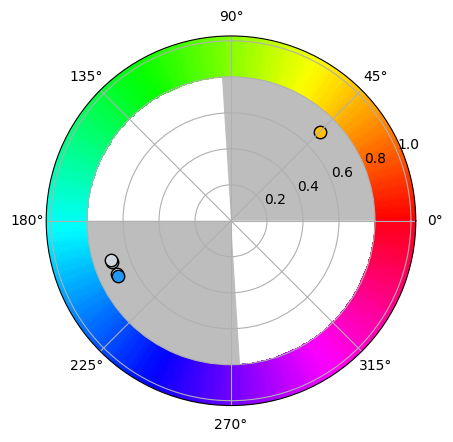

In [107]:
# ------ plot color point on the hue curcle ------
fig = plt.figure()

# hue wheel
theta = np.linspace(0, 2*np.pi, 360)
r = np.random.uniform(0.8, 1, 360)
T, R = np.meshgrid(theta, r)
C = T / (2*np.pi)

ax = fig.add_subplot(111, projection='polar')
# ax.set_axis_off()
ax.pcolormesh(T, R, C, cmap=cm.hsv)

# plot template region
a0, a1, b0, b1 = region * np.pi / 180
theta = np.linspace(a0, a1, 100)
ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')
theta = np.linspace(b0, b1, 100)
ax.fill_between(theta, 0.8, color='#bdbdbd', edgecolor='none')

# color points
for angle, c in zip(hue, rgb):
    ax.scatter(angle*np.pi/180, 0.7, color=c, s=80, marker='o', edgecolors="black")
plt.show()